# Deep Learning Lab: EE-045107
## Meeting 4: Denoising Diffusion Probabilistic Models
## Part I: Toy example
### [Elias Nehme](https://eliasnehme.github.io/), <span style="color:red">Mar 03, 2024</span>

###  Submission Guidelines

* Submission on the course website (Moodle).
* Working environment:
    * You can work in `Jupyter Notebook` online using <a href="https://colab.research.google.com/">Google Colab</a> as it does not require any installation.
    * You can also work locally after installing the environment from the `requirements.txt` file using `pip`.
* You should submit two **separated** files:
    * A `.ipynb` file, with the name: `ee045107_meeting4_id1_id2_part1.ipynb` which contains your code implementations.
    * A `.pdf` file, with the name: `ee045107_meeting4_id1_id2_part1.pdf` which is your report containing **all the plots, answers, and discussions**.
      * if you see a <img src="assets/code_task_icon.png" style="height:30px;display:inline\">, complete the code and copy the relevant figures to the report.
      * if you see a <img src="assets/write_task_icon.png" style="height:30px;display:inline\"> icon, it means you need to answer the question in the report.
    * **No handwritten submissions** and no other file-types (`.docx`, `.html`, ...) will be accepted.

### Mounting your drive for saving/loading stuff

In [1]:
# relevant only if you work in google Colab
# from google.colab import drive
# drive.mount('/content/drive')

### Importing relevant libraries

In [2]:
## Standard libraries
import numpy as np
import math

## Progress bar
import tqdm.notebook as tqdm

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
plt.style.use('ggplot')

## Pytorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# device to be used (preferably a GPU, change Colab runtime type if needed)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

Using device cuda:0


## Introduction

In this lab we will get familiar with Diffusion models ([1](https://arxiv.org/pdf/1503.03585.pdf)),([2](https://arxiv.org/pdf/2006.11239.pdf)). Diffusion models are inspired by non-equilibrium thermodynamics. They define a Markov chain of diffusion steps to slowly add random noise to data (*forward process*) and then learn to reverse the diffusion process (*reverse process*) to construct desired data samples from noise.

#### Forward diffusion process

Given a data point sampled from a real data distribution $\mathbf{x}_0\sim q(\mathbf{x}_0)$, we define a forward diffusion process in which we add small amounts of Gaussian noise to the sample in $T$ steps, producing a sequence of noisy samples $\mathbf{x}_1,\dots,\mathbf{x}_T$. The step sizes are controlled by a variance schedule $\beta_1,\dots,\beta_T$, such that
$$q(\mathbf{x}_{1:T}\lvert \mathbf{x}_0) = \prod_{t=1}^Tq(\mathbf{x}_t\lvert\mathbf{x}_{t-1}), \ \ \ \ \ \ q(\mathbf{x}_t\lvert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t;\sqrt{1-\beta_t}\mathbf{x}_{t-1},\beta_t \mathbf{I})$$
The data sample $\mathbf{x}_0$ gradually loses its distinguishable features as the step $t$ becomes larger. Eventually when $T\rightarrow\infty$, $\mathbf{x}_T$ is equivalent to an isotropic Gaussian distribution.

#### Reverse diffusion process

If we can reverse the above process and sample from $q(\mathbf{x}_{t-1}\lvert\mathbf{x}_t)$, we will be able to recreate the true sample from a Gaussian noise input $\mathbf{x}_T\sim \mathcal{N}(\mathbf{0},\mathbf{I})$. Note that if $\beta_t$ is small enough, $q(\mathbf{x}_{t-1}\lvert\mathbf{x}_t)$ will also be Gaussian. Unfortunately, we cannot easily estimate $q(\mathbf{x}_{t-1}\lvert\mathbf{x}_t)$ because it needs to use the entire dataset and therefore we need to learn a model $p_{\theta}(\mathbf{x}_{t-1}\lvert\mathbf{x}_t)$ to approximate these conditional probabilities in order to run the reverse diffusion process:
$$p_{\theta}(\mathbf{x}_{0:T}) = p(\mathbf{x}_T)\prod_{t=1}^T p_{\theta}(\mathbf{x}_{t-1}\lvert\mathbf{x}_t), \ \ \ \ \ \ p_{\theta}(\mathbf{x}_{t-1}\lvert\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1};\mathbf{\mu}_{\theta}(\mathbf{x}_t,t),\mathbf{\Sigma}_{\theta}(\mathbf{x}_t,t)).$$
In practice, we will assume the reverse process have an untrained diagonal covariance $\mathbf{\Sigma}_{\theta}(\mathbf{x}_t,t)=\sigma_t^2\mathbf{I}$ with time depedent constants $\sigma_t^2=\beta_t$.

#### Summarizing figure

Both processes and the learning objective are exemplified in this edited figure from the [DDPM paper](https://arxiv.org/pdf/2006.11239.pdf) (figure credit - [Lilian Weng](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)):
<center width="100%"><img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png" width="800px"></center>

Recently, diffusion models have obtained high-quality samples and are widely considered to be the current state-of-the-art. For the sake of simplicity, in this part of the lab we will work with a two-dimensional toy example to enhance our understanding.

## Toy 2D implementation

In this part we will implement denoising diffusion models and apply them to multiple toy 2D datasets. For your convience, the provided function `sample_2d_datasets` samples from 4 different toy datasets that we will use for this part. The supported options in this function are `{'Spiral', 'Circles', 'Moons', 'GaussiansRot'}`, where for the last distribution `'GaussiansRot'`, the function supports a varying number of gaussians using the parameter `num_gaussians`.

In [3]:
## Scikit-learn built-in dataset generators
from sklearn.datasets import make_moons, make_circles, make_blobs, make_swiss_roll

def sample_2d_datasets(dist_type, num_samples=1000, seed=0, num_gaussians=5):
  """
  function samples from simple pre-defined distributions in 2D.
  Inputs:
    - dist_type: str specifying the distribution to be chosen from:
      {'Spiral', Circles', 'Moons', 'GaussiansRot'}
    - num_samples: Number of samples to draw from dist_type (int).
    - seed: Random seed integer.
    - num_gaussians: Number of rotated gaussians if dist_type='GaussiansRot'. 
      (relevant only for dist_type='GaussiansRot', should be a keyword argument)
  Outputs:
    - data (np.array): array of num_samplesx2 samples from dist_type
  """
  np.random.seed(seed)
  if dist_type == 'Spiral':
    data = make_swiss_roll(num_samples, noise=0.0, random_state=seed)[0]
    data = data[:,[0,2]]
  elif dist_type == 'Circles':
    data = make_circles(num_samples, noise=0.01, factor=0.5, random_state=seed, shuffle=True)[0]
  elif dist_type == 'Moons':
    data = make_moons(num_samples, noise=.01, random_state=seed, shuffle=True)[0]
  elif dist_type == 'GaussiansRot':
    angles = np.linspace(0, 2 * np.pi, num_gaussians, endpoint=False)
    centers = np.stack([2.5 * np.array([np.cos(angle), np.sin(angle)]) for angle in angles])
    data = make_blobs(num_samples, centers=centers, cluster_std=np.sqrt(.1), random_state=seed, shuffle=True)[0]
  else:
    raise NotImplementedError
  data = 2.*(data - data.min(axis=0))/(data.max(axis=0) - data.min(axis=0)) - 1.
  return data

<img src="assets/code_task_icon.png" style="height:30px;display:inline\"> **<span style="color:red">Task 1</span>**. To get acquainted with this function, for each of the 4 distributions above, draw $N = 1000$ samples $\{\mathbf{x}_i\}$. Display the drawn samples for each distribution in a separate plot.

Distribution of:  Spiral


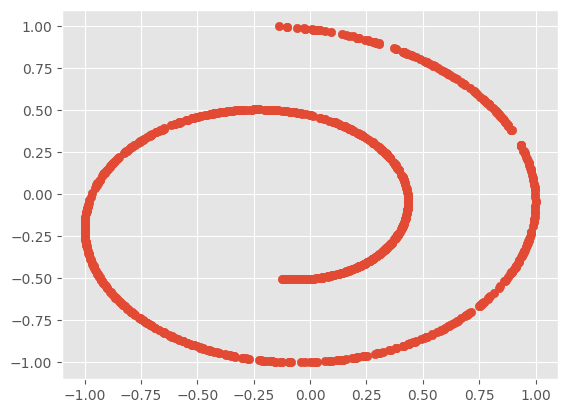

Distribution of:  Circles


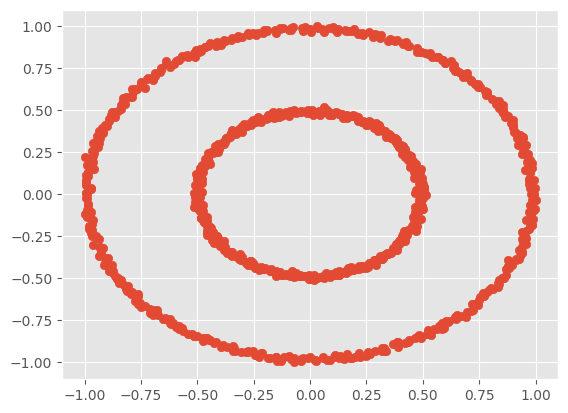

Distribution of:  Moons


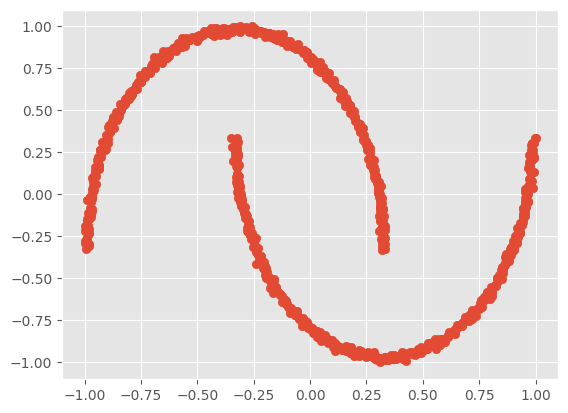

Distribution of:  GaussiansRot


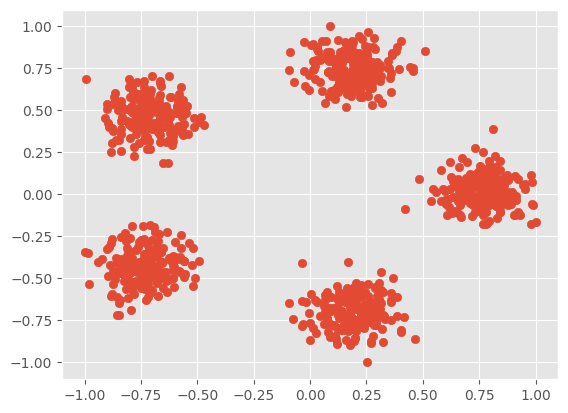

In [4]:
# TODO: display the drawn samples for each of the 4 distributions in a separate plot.
types_of_dist= ['Spiral', 'Circles', 'Moons', 'GaussiansRot']
dists = []
for dist_type in types_of_dist:
    dists.append(sample_2d_datasets(dist_type, 1000, seed=42))
    print("Distribution of: ", dist_type)
    plt.scatter(dists[-1][:,0],dists[-1][:,1])
    plt.show()

For a starter, we will focus in particular on the `Spiral` distribution used in the [2015 paper](https://arxiv.org/pdf/1503.03585.pdf) which proposed diffusion models for the first time. Before we delve into implementing the forward and reverse diffusion processes, let us first cover some implementation details. 

#### Simplified loss & training algorithm

In practice, the authors of [DDPM](https://arxiv.org/pdf/2006.11239.pdf) found it beneficial to sample quality (and simpler to implement) to train on the following variant of the variational bound:

$$L_{\text{simple}}(\theta) = \mathbb{E}_{t,\mathbf{x}_0,\mathbf{\epsilon}}\left[\|\mathbf{\epsilon} - \mathbf{\epsilon}_{\theta}(\sqrt{\bar{\alpha}_t}\mathbf{x}_0+\sqrt{1-\bar{\alpha}_t}\mathbf{\epsilon},t)\|^2\right]$$

where $t$ is uniform between $1$ and $T$. Therefore, training a noise model $\mathbf{\epsilon}_{\theta}(\mathbf{x}_t,t)$ to optimize the above objective with SGD is given by:


<!--<center width="100%"><img src="https://drive.google.com/uc?id=1THxWyCWF6jzG5v0QfKrMlo4oxJeS0pUL" width="300px"></center>-->

<center width="100%"><img src="assets/training_algo.png" width="600px"></center>

In other words:
* We take a random sample $\mathbf{x}_0$ from the real unknown (complex) data distribution $q(\mathbf{x}_0)$ 
* We sample a noise level $t$ uniformly between $1$ and $T$ (i.e., a random time step)
* We sample some noise $\epsilon$ from a Gaussian distribution $\mathcal{N}(\mathbf{0},\mathbf{I})$ and corrupt the input by this noise at level $t$ using the reparameterization of $q(\mathbf{x}_t\lvert\mathbf{x}_0)$
* The neural network is trained to predict this noise based on the corrupted sample $\mathbf{x}_t$ (i.e. noise applied on $\mathbf{x}_0$ based on a known schedule $\beta_t$).

In reality, all of this is done on batches of data, as one uses stochastic gradient descent to optimize neural networks.

#### Sampling a trained model

Generating new samples from a diffusion model happens by reversing the diffusion process: we start from $T$, where we sample pure noise from a Gaussian distribution, and then use our neural network to gradually denoise it (using the conditional probability it has learned), until we end up at time step $t=0$:


<!--<center width="100%"><img src="https://drive.google.com/uc?id=1Cjd-K8kYifUxjP8gw2rMrrrkYZa2aAxB" width="300px"></center>-->

<center width="100%"><img src="assets/sampling_algo.png" width="600px"></center>

As shown above, we can derive a slighly less noisy sample $\mathbf{x}_{t-1}$ by plugging in the reparametrization of the mean, using our noise predictor $\mathbf{\epsilon}_{\theta}(\mathbf{x}_t,t)$ and the predefined variance constants $\alpha_t$, $\bar{\alpha}_t$, and $\sigma_t$. Ideally, we end up with a sample that looks like it came from the real data distribution.

#### Forward and reverse processes

For your convenience, we provide below the class `DiffusionModel`. This class implements both the forward diffusion process using the method `diffuse`, and the reverse diffusion process using the method `denoise`. The class is initialized with the following:
* `eps_model` - model $\mathbf{\epsilon}_{\theta}(\mathbf{x}_t,t)$ used to predict the noise of diffused images.
* `T` - total number of diffusion steps $T$.
* `beta1` - first variance in the variance scheduler $\beta_1$. 
* `betaT` - last variance in the variance scheduler $\beta_T$.
* `device` - the device to run calculations on (either cpu or gpu).

Using the provided initialization, the class calculates the variance schedule `self.betas` linearly spaced in $\left[\beta_1,\beta_T\right]$, and derive from it multiple useful properties including:
* `self.sigmas` - the standard deviations of $p_{\theta}(\mathbf{x}_{t-1}\lvert\mathbf{x}_t)$ assuming $\Sigma_{\theta}(\mathbf{x}_t,t)=\sigma_t^2\mathbf{I}=\beta_t\mathbf{I}$.
* `self.alphas` and `self.alphas_bar` - $\alpha_t=1-\beta_t$ and $\bar{\alpha}_t=\prod_{s=1}^t\alpha_s$ respectively.
* `self.sqrt_alphas_bar` and `sqrt_1_minus_alphas_bar` - $\sqrt{\bar{\alpha}_t}$ and $\sqrt{1-\bar{\alpha}_t}$.
* `self.inv_sqrt_alphas`, `self.inv_sqrt_alphas_bar`, and `self.pre_noise_terms` - $\frac{1}{\sqrt{\alpha_t}}$, $\frac{1}{\sqrt{\bar{\alpha}_t}}$, and $\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}$.


In [5]:
# class for diffusion models
class DiffusionModel:
    def __init__(self, eps_model, T=40, beta1=2e-4, betaT=2.25e-3, device="cpu"):
        """
        Implements the forward and the reverse diffusion processes
        :param eps_model (torch.nn.Module): model used to predict noise of diffused images
        :param T (int): total number of diffusion steps
        :param beta1 (float): first beta for variance scheduler
        :param betaT (float): last beta for variance scheduler
        :param device (string): torch device to place tensors and eps_model on
        """
        # basic properties
        self.device = device
        self.eps_model = eps_model.to(device)
        self.T = T
        self.betas = torch.linspace(beta1, betaT, self.T).to(device)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, axis=0)
        self.sigmas = torch.pow(self.betas, 0.5)

        # pre-calculations of useful terms
        self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar)
        self.sqrt_1_minus_alphas_bar = torch.sqrt(1 - self.alphas_bar)
        self.inv_sqrt_alphas = torch.pow(self.alphas, -0.5)
        self.inv_sqrt_alphas_bar = torch.pow(self.alphas_bar, -0.5)
        self.pre_noise_terms = self.betas / self.sqrt_1_minus_alphas_bar

    def diffuse(self, x0, t):
        """
        Diffuses x0 for t steps according to q(xt|x0).
        :param x0 (torch.Tensor): 2d data points to diffuse
        :param t (torch.Tensor): number of diffusion time steps
        :return eps (torch.Tensor): sampled noises eps
        :return xt (torch.Tensor): diffused/noisy data points xt
        """
        
        # TODO: Complete the code
        eps = (torch.randn_like(x0)).to(self.device)
        # NOTE: lines 22-26 in this cell contain relevant ARRAYS of multiplier constants
        xt = self.sqrt_alphas_bar[t-1]*x0 + self.sqrt_1_minus_alphas_bar[t-1]*eps
        return eps, xt

    def denoise(self, xt, t):
        """
        Denoises random samples xt for t steps to produce x0~p(x0|xt).
        :param xt (torch.Tensor): initial 2d data points to denoise
        :param t (torch.Tensor): number of denoising time steps
        :return x0 (torch.Tensor): samples from x0~p(x0|xt). 
        :return all_epst (List[torch.Tensor]): list of predicted noises epst along the trajectory xt->x0
        :return all_x0t (List[torch.Tensor]): list of estimates x0t along the trajectory xt->x0
        :return all_x0t (List[torch.Tensor]): list of estimates xt along the trajectory xt->x0
        """
        
        # TODO: complete the code
        n_samples = 1 if len(xt.shape) > 1 else xt.shape[0]
        all_xt, all_x0t, all_epst = [xt], [], []
        for i in range(t, 0, -1):
            z = (torch.randn_like(xt)).to(self.device) if t >1 else torch.zeros_like(x0).to(self.device)
            timesteps = torch.full((n_samples,),
                                   i,
                                   dtype=torch.int,
                                   device=self.device).unsqueeze(1)
            epst = self.eps_model(xt,timesteps)
            # NOTE: remember, lines 22-26 in this cell contain relevant ARRAYS of multiplier constants
            x0t = self.inv_sqrt_alphas[i-1]*(xt-self.sqrt_1_minus_alphas_bar[i-1]*epst)
            xt = self.inv_sqrt_alphas[i-1]*(xt-self.pre_noise_terms[i-1]*epst) + self.sigmas[i-1]*z
            # recording trajectory
            all_epst.append(epst.detach())
            all_x0t.append(x0t.detach())
            all_xt.append(xt.detach())
        x0 = xt
        return x0, all_epst, all_x0t, all_xt

<img src="assets/code_task_icon.png" style="height:30px;display:inline\"> **<span style="color:red">Task 2</span>**. Implement the two missing methods `diffuse` and `denoise` in the provided class `DiffusionModel`. 
* The method `diffuse` accepts `x0` a batch of $B\times 2$ samples from $q(\mathbf{x}_0)$, and `t` a batch of $B \times 1$ timesteps sampled uniformly from $\{1,\dots,T\}$. The returned results are:
    * `eps` a batch of $B \times 2$ noises $\mathbf{\epsilon}$ sampled from $\mathcal{N}(\mathbf{0},\mathbf{I})$.
    * `xt` a batch of $B \times 2$ diffused/noisy samples $\mathbf{x}_t$ from $q(\mathbf{x}_t\lvert \mathbf{x}_0)$.
* The method `denoise` accepts `xt` a batch of $B\times 2$ noisy samples $\mathbf{x}_t$, and `t` a matching **scalar** timestep $t$ in $\{1,\dots,T\}$. The returned results are:
    * `x0` a batch of $B \times 2$ denoised samples $\mathbf{x}_0$ from $p_{\theta}(\mathbf{x}_0\lvert\mathbf{x}_t)$.
    * `all_epst` a list of `t` batches of $B\times 2$ predicted noises $\mathbf{\epsilon}_{\theta}(\mathbf{x}_t,t)$ along the trajectory $\mathbf{x}_t\rightarrow\mathbf{x}_0$.
    * `all_x0t` a list of `t` batches of $B \times 2$ estimates of $\hat{\mathbf{x}}_0^t$ along the trajectory $\mathbf{x}_t\rightarrow\mathbf{x}_0$.
    * `all_xt` a list of `t+1` batches of $B \times 2$ denoised samples $\mathbf{x}_{t-1}$ along the trajectory $\mathbf{x}_t\rightarrow\mathbf{x}_0$ including the starting point.

**Remark**: Note that the variable `t` functions differently in the methods `diffuse` and `denoise`. In `diffuse` it is a vector of $B$ potentially *different* scalars, one per batch element $\mathbf{x}_0^i$ for $i\in\{1,\dots,B\}$. Meaning, every batch element is added a potentially *different* amount of noise during the forward process. On the other hand, in the reverse process implemented using the method `denoise`, the variable `t` is a scalar denoting the timestep of *all* noisy samples `xt`. During training of course we have to handle noisy samples with different timesteps, but that will be done using the noise model `eps_model` directly as explained later.  
Moreover, note that in the `denoise` method **the loop should run in the reversed order from `t` to 0**. 

#### Time-depedent architecture

A key component in learning an efficient time-depedent noise model $\mathbf{\epsilon}(\mathbf{x}_t,t)$ is to condition the architecture on $t$ and make it adapt the prediction according to the noise scheduler. Here, we will follow a common strategy to condition the model on $t$. Specifically, we will first embed $t_i\in\{1,\dots,T\}$ into a vector $e(t_i)\in\mathbb{R}^{d_e\times 1}$ using a technique known as *Sinusoidal Positional Encoding*, first proposed in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762). The main idea is to represent each timestep $t$ by some higher order vector $e(t)$ that makes it easier for the noise prediction network $\epsilon_{\theta}(\mathbf{x}_t,t)$ to adapt the weights $\theta$. Those of you interested in further theoretical details on why this is a good idea are referred to [paper 1](https://arxiv.org/pdf/1806.08734.pdf?ref=sair.synerise.com) and [paper 2](https://arxiv.org/pdf/2006.10739.pdf). For your convience, the class `SinusoidalPositionEmbeddings` provided below implements the aforementioned positional encoding technique.

In [6]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.half_dim = self.dim // 2
        self.max_freq = math.log(10000) / (self.half_dim - 1)
        self.freqs = torch.exp(torch.arange(self.half_dim) * -self.max_freq)

    def forward(self, time):
        embeddings = self.freqs.to(time.device)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.stack((embeddings.cos(), embeddings.sin()), dim=-1).view(-1,self.dim)
        return embeddings

<img src="assets/code_task_icon.png" style="height:30px;display:inline\"> **<span style="color:red">Task 3</span>**. Using the class above, show the resulting encodings $e(t)$ for dimension $d_e=32$ (i.e. `dim=32`) for every $t\in\{1,\dots,T\}$ with $T=40$. The module expects to receive `t` as a one dimensional tensor. You can use `torch.linspace(0,40,41)` to pass in all $t$'s at once. To visually examine the difference between $e(t_i)$ and $e(t_j)$ for some $t_i\neq t_j$, show the resulting vectors $e(t_i)$ as a matrix such that $t_i$ is the $x$ axis and $e(t_i)$ is the y-axis.  
<img src="assets/write_task_icon.png" style="height:30px;display:inline\"> Discuss the resulting matrix. You've seen in the last meeting that we use positional embedding to keep track of the order in a sentence. How does it help us here, where no text is used?  

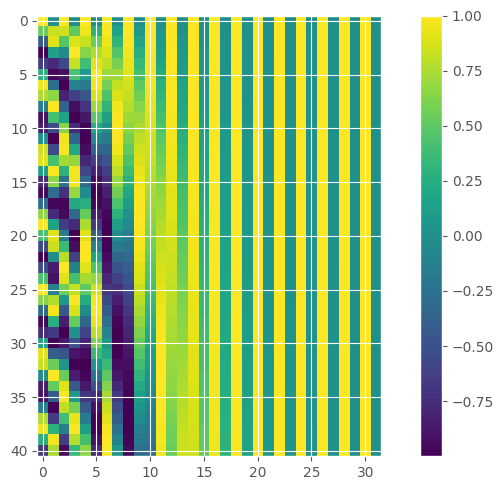

In [7]:
# TODO: instantiate the class above and with the vector torch.linspace(0,40,41) and plot e(ti) using imshow
time = torch.linspace(0,40,41)
sinpose32 = SinusoidalPositionEmbeddings(32)
image = sinpose32(time)
plt.figure(figsize=(8,5))
plt.imshow(image)
plt.colorbar()
plt.tight_layout()

In this part of the lab, we will use a simple fully connected architecture with each block `MlpBlock` conditioned on both $x_t$ and $t$ as follows:

In [8]:
# basic building block for time-conditional MLP
class MlpBlock(nn.Module):
    def __init__(self, dim_in=32, dim_out=32, dim_t=32):
        super(MlpBlock, self).__init__()
        self.x_mlp = nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU())
        self.t_mlp = nn.Sequential(nn.Linear(dim_t, dim_out))
        self.silu = nn.SiLU()
        
    def forward(self, x, t):
        x = self.x_mlp(x)
        t = self.t_mlp(t)
        return self.silu(x + t)

The overall architecture $\mathbf{\epsilon}_{\theta}(\mathbf{x}_t,t)$, first encodes $t$ using the sinusoidal positional encoding technique and then uses several `MlpBlock` layers as follows:

In [9]:
# entire noise model
class NoiseModel(nn.Module):
    def __init__(self, dim_hid=256, dim_t=256):
        super(NoiseModel, self).__init__()
        self.pos_enc = SinusoidalPositionEmbeddings(dim_t)
        self.layer_t = nn.Sequential(nn.Linear(dim_t, dim_hid), 
                                     nn.SiLU(), 
                                     nn.Linear(dim_hid, dim_hid), 
                                     nn.SiLU())
        self.layer1 = MlpBlock(dim_in=2, dim_out=dim_hid, dim_t=dim_t)
        self.layer2 = MlpBlock(dim_in=dim_hid, dim_out=dim_hid, dim_t=dim_t)
        self.layer3 = MlpBlock(dim_in=dim_hid, dim_out=dim_hid, dim_t=dim_t)
        self.layer_out = nn.Linear(dim_hid, 2)

    def forward(self, x, t):
        
        # time embedding
        t = self.pos_enc(t)
        t = self.layer_t(t)
        
        # time-conditional layers
        x = self.layer1(x, t)
        x = self.layer2(x, t)
        x = self.layer3(x, t)
        x = self.layer_out(x)
        return x

<img src="assets/code_task_icon.png" style="height:30px;display:inline\"/> **<span style="color:red">Task 4</span>**. Sample 102,400 samples $\{\mathbf{x}_i\}$ from the `Spiral` distribution using the function `sample_2d_datasets`. These will constitute our training samples $\mathbf{x}_0\sim q(\mathbf{x}_0)$. Initialize the class `DiffusionModel` with the noise model `NoiseModel()` using the default parameters, and `T=40, beta1=2e-4, betaT=2.25e-3` with the available device `device`. Apply the class method `DiffusionModel.diffuse()` to the samples $\{\mathbf{x}_i\}$ and show the resulting samples $\{\mathbf{x}_t\}$ for $t\in\{1,10,19,28,37\}$.

<img src="assets/write_task_icon.png" style="height:30px;display:inline\"/> Discuss the behaviour as a function of $t$ (creating an animation can help here, but don't waste too much time on it).

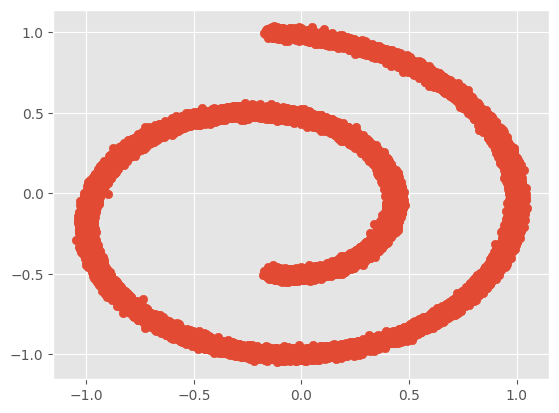

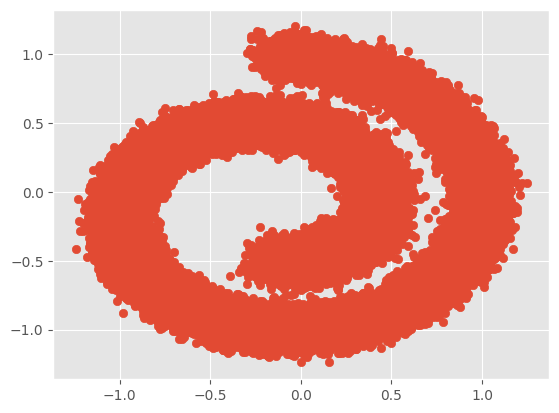

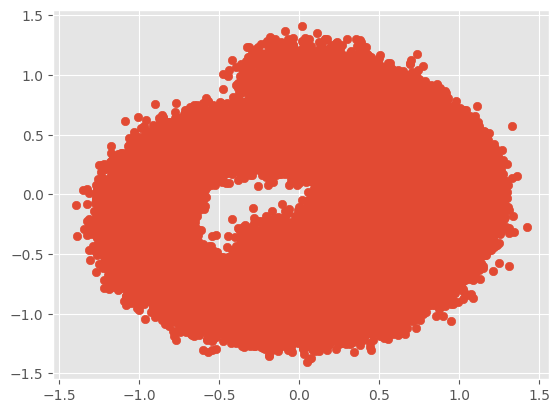

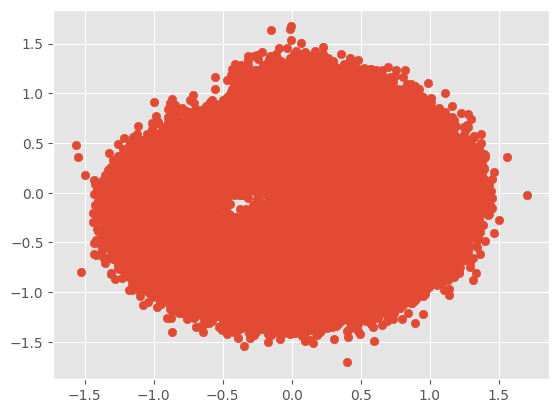

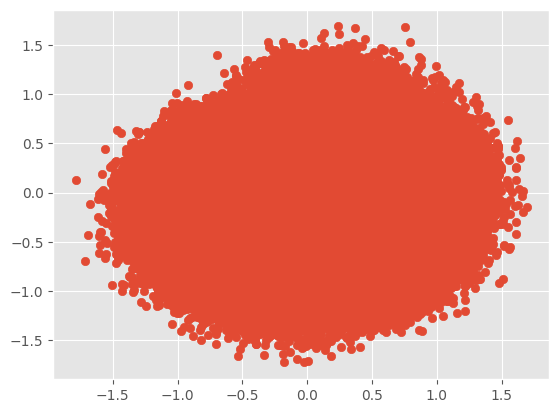

In [10]:
# TODO: Complete the code
data = sample_2d_datasets("Spiral", 102400, seed=42)
x0 = (torch.from_numpy(data).to(device))
eps_model = NoiseModel()
diffuser = DiffusionModel(eps_model, T=40, beta1=2e-4, betaT=2.25e-3, device=device)

for t in [1, 10, 19, 28, 37]:
    _, diffused = diffuser.diffuse(x0,t)
    diffused = diffused.cpu()
    plt.scatter(diffused[:,0], diffused[:,1])
    plt.show()

In [11]:
diffused[1].shape

torch.Size([2])

#### Training loss

Now that we have a class modelling the forward and the reverse processes and an architecture, we are ready to implement the training steps from Algorithm 1.

<img src="assets/code_task_icon.png" style="height:30px;display:inline\"> **<span style="color:red">Task 5</span>**. Implement the loss function $L_{\text{simple}}(\theta)$. Your function should accept three inputs:
 * `x0` - the current batch of $B \times 2$ training samples $\mathbf{x}_0$.
 * `t` - $B \times 1$ tensor indicating the used timesteps $t$ corresponding to each sample in the batch.
 * `diffuser` - a `DiffusionModel` instance with a `diffuse` method and a noise model attribute `eps_model`.

In [12]:
def calc_loss(x0, t, diffuser):
    """
    Diffuses samples x0 for t steps to get xt and the ground truth noise eps
    Next, xt is fed to eps_model to predict the noise eps_pred and both noises are compared using L2 loss
    :param x0 (torch.Tensor): samples from x0~p(x0|xt).
    :param t (torch.Tensor): number of noise timesteps per sample
    :return loss (torch.Tensor): scalar mean L2 distance between the ground truth and predicted noise.
    """
    
    # TODO: Fill in your code to calculate the loss
    # Remember: Use the diffuse method and eps_model attributes of diffuser
    eps, xt = diffuser.diffuse(x0,t)
    eps_pred = diffuser.eps_model(xt,t)
    
    # loss = torch.mean(torch.norm(eps-eps_model,dim=1)**2)
    loss = torch.mean((eps-eps_pred)**2)
    return loss

#### Training

For your convience, below is a training function `train` using the implemented loss function internally to train. This function accepts the following inputs:
* `data` - a $N\times 2$ dataset of samples $\mathbf{x}_0\sim q(\mathbf{x}_0)$.
* `batch_size, nepochs` - the batch size for training (default 1024) and the number of training epochs (default 50).
* `T, beta1, betaT`- the number of diffusion steps $T$ (default 40), and $\beta_1$,$\beta_T$ (defaults 2e-4, 2.25e-3) controlling the variance scheduler.
* `device` - device to train on.

After training is done (~roughly 1 minute on a standard colab GPU), the function returns a `DiffusionModel` instance in `diffuser`, and a list of training losses `all_losses` for sanity check.

In [13]:
def train(data, batch_size=1024, nepochs=50, T=40, beta1=2e-4, betaT=2.25e-3, device="cuda"):
    
    # dataset and dataloader
    my_dataset = TensorDataset(torch.Tensor(data))
    my_dataloader = DataLoader(my_dataset, batch_size=batch_size)
    
    # noise model and diffuser class
    eps_model = NoiseModel()
    diffuser = DiffusionModel(eps_model, T, beta1, betaT, device)
    diffuser.eps_model.train()

    # optimizer
    optimizer = torch.optim.Adam(diffuser.eps_model.parameters(), lr=0.001)

    # train (overfitting prevented by early stopping)
    all_losses = []
    with tqdm.tqdm(range(nepochs), unit=' Epoch') as tepoch:
        for epoch in tepoch:
            for batch in my_dataloader:
            
                # batch of x0 and random ts
                x0 = batch[0].to(device)
                t = torch.randint(1, T+1, (len(x0),)).unsqueeze(1).to(device)

                # calculate loss
                loss = calc_loss(x0, t, diffuser)

                # backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # record all losses for sanity check
                loss_step = loss.detach().item()
                all_losses.append(loss_step)
            
            # report progress with tqdm pbar
            tepoch.set_postfix(train_loss=loss_step)
    return diffuser, all_losses

<img src="assets/code_task_icon.png" style="height:30px;display:inline\"> **<span style="color:red">Task 6</span>**. Train a diffusion model using the provided function `train` with `data` being the samples from Task 4. Use the default parameters `batch_size=1024, nepochs=50, T=40, beta1=2e-4, betaT=2.25e-3`. For sanity check, plot the training loss progression in `all_losses`.

  0%|          | 0/50 [00:00<?, ? Epoch/s]

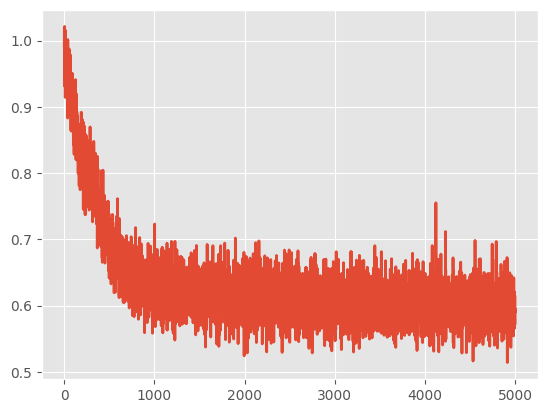

In [14]:
# TODO: Complete the sanity check
diffuser, all_losses = train(data, batch_size=1024, nepochs=50, T=40, beta1=2e-4, betaT=2.25e-3, device=device)

plt.plot(all_losses)
plt.show()

#### Sampling

Now that we have a trained diffusion model given in `diffuser` we can finally sample from $p_{\theta}(\mathbf{x}_0)=\int p_{\theta}(\mathbf{x}_{0:T})d\mathbf{x}_{1:T}$ and compare the result to the original samples in `data`. This can be achieved by sampling $\mathbf{x}_T\sim p(\mathbf{x}_T)=\mathcal{N}(\mathbf{0},\mathbf{I})$ and applying the `denoise` method we implemented earlier in Task 2 starting from `t=T=40`.

<img src="assets/code_task_icon.png" style="height:30px;display:inline\"/> **<span style="color:red">Task 7</span>**. Sample $N=2048$ samples from $p_{\theta}(\mathbf{x}_0)$ using the trained `diffuser`, and plot the resulting samples `x0` using a scatter plot.

<img src="assets/write_task_icon.png" style="height:30px;display:inline\"/> Discuss the result in comparison to the samples in `data`.

Text(0.5, 1.0, 'Samples from $q(\\mathbf{x}_0)$')

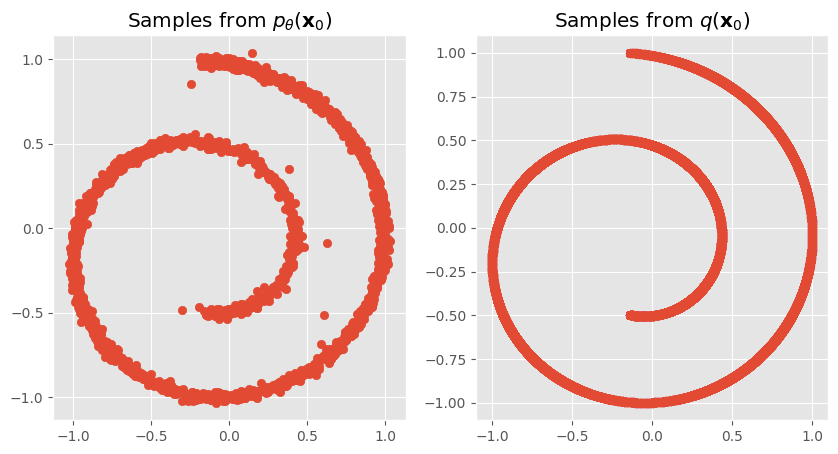

In [15]:
# TODO: diffuse the samples
eval_data = (torch.randn(2048,2)).to(device)
diffuser.eps_model.eval()
with torch.no_grad():
     x0_tag, all_epst, all_x0t, all_xt = diffuser.denoise(eval_data, 40)
x0_tag = x0_tag.cpu()
x0 = x0.cpu()
# Plot the samples.
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x0_tag[:,0],x0_tag[:,1])
plt.title(r'Samples from $p_{\theta}(\mathbf{x}_0)$')
plt.subplot(1,2,2)
plt.scatter(x0[:,0],x0[:,1])
plt.title(r'Samples from $q(\mathbf{x}_0)$')

In [16]:
x0_tag.shape

torch.Size([2048, 2])

Next, the method `denoise` additionally returns intermediate outputs along the trajectory $\mathbf{x}_T\rightarrow\mathbf{x}_0$. 

<img src="assets/code_task_icon.png" style="height:30px;display:inline\"/> **<span style="color:red">Task 8</span>**. Use scatter plots to show the progression of the samples $\hat{\mathbf{x}}_0^t$ (given in `all_x0t`) and $\mathbf{x}_{t-1}$ (given in `all_xt`) along the trajectory $\mathbf{x}_T\rightarrow\mathbf{x}_0$ for $t\in\{1,10,19,28,37\}$. 

<img src="assets/write_task_icon.png" style="height:30px;display:inline\"/> Discuss the behaviour as a function of $t$ (creating an animation can help here, but don't waste too much time on it).

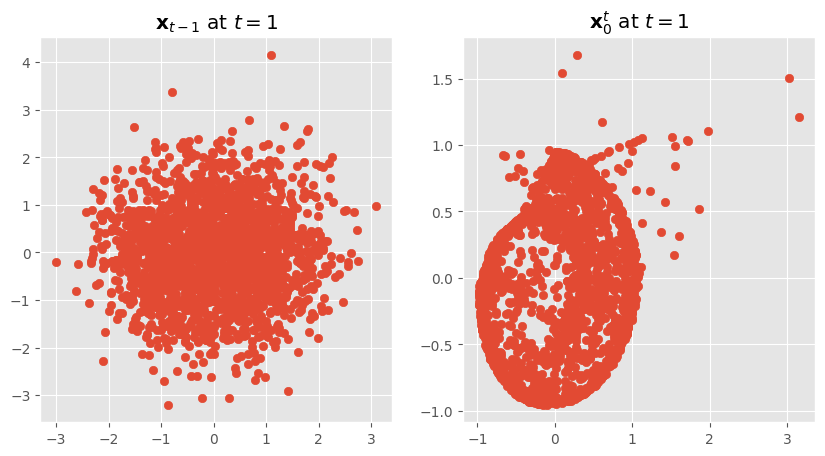

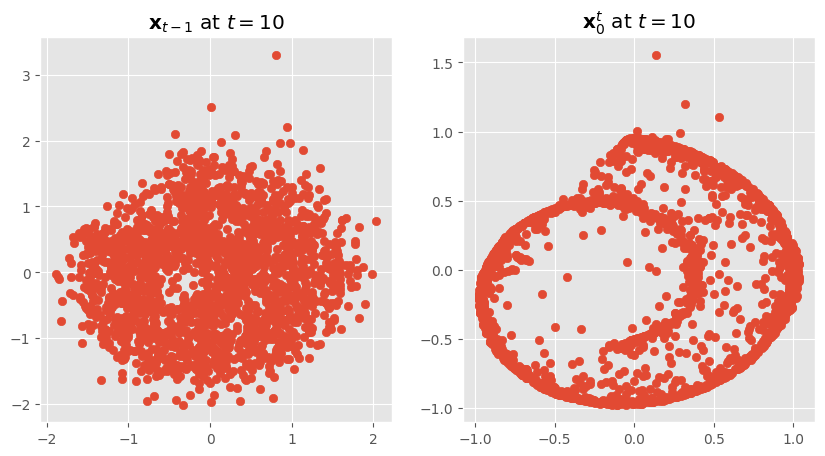

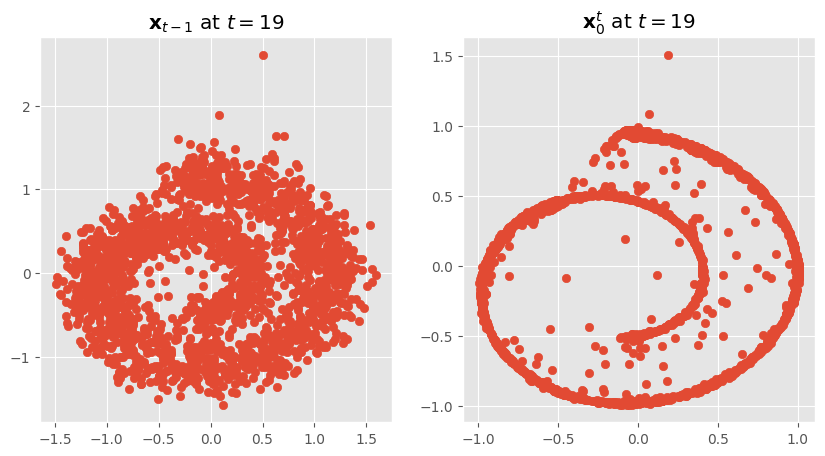

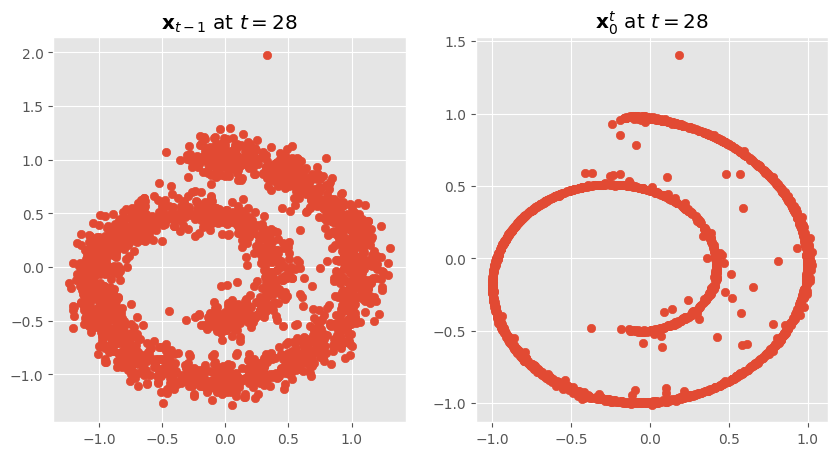

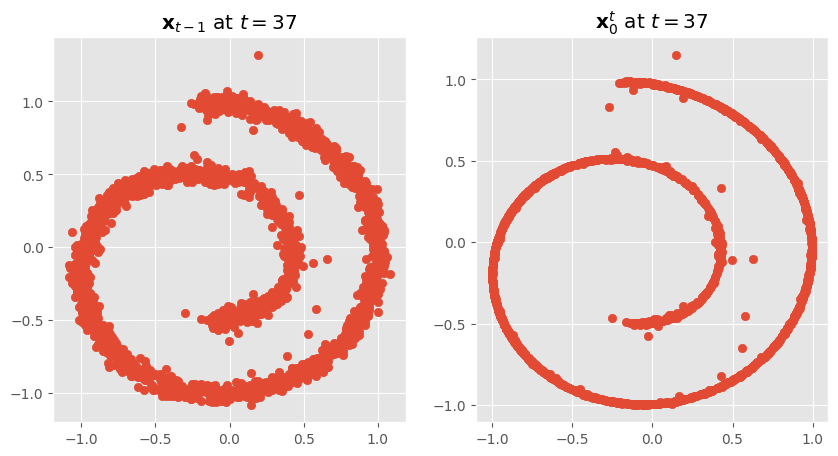

In [17]:
# TODO: show the progression of the samples.
for t in [1, 10, 19, 28, 37]:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    xt = all_xt[t].cpu()
    # NOTE: Make sure you choose the correct timestep!
    plt.scatter(xt[:,0], xt[:,1])
    plt.title(r'$\mathbf{x}_{t-1}$' + fr' at $t={t}$')
    plt.subplot(1,2,2)
    x0t = all_x0t[t].cpu()
    # NOTE: Make sure you choose the correct timestep!
    plt.scatter(x0t[:,0], x0t[:,1])
    plt.title(r'$\mathbf{x}_0^t$' + fr' at $t={t}$')
    plt.show()

## <img src="assets/icons8-training-64.png" style="height:30px;display:inline\"> <span style="color:red">CALL YOUR INSTRUCTOR BEFORE CONTINUING</span>

#### Connection to score-matching

At first glance, it is not intuitive to understand how diffusion models can denoise pure Gaussian noise to result in data samples. However, behind the predicted noises by our model lies a well established theoretical framework called [*Score Matching*](https://jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf). The score function of a distribution $p(\mathbf{x})$ is defined as $\nabla_{\mathbf{x}} p(\mathbf{x})$. Given this function, we are able to sample from $p(\mathbf{x})$ using Markov Chain Monte Carlo (MCMC) methods such as Langevin dynamics. Let $\mathbf{x}_t$ be a noisy/perturbed version of the original samples $\mathbf{x}_0$. Turns out, the training of diffusion models as we carried out above leads our parameterized noise model to predict the score $\nabla_{\mathbf{x}_t}\log q(\mathbf{x}_t)$ up to a constant:  
$$-\frac{1}{\sqrt{1-\bar{\alpha}_t}} \cdot \epsilon_{\theta}(\mathbf{x}_t,t) \approx \nabla_{\mathbf{x}_t}\log q(\mathbf{x}_t).$$ 
Those of you interested in the exact theoretical details are encouraged to read the unified framework using [stochastic differential equations](https://openreview.net/pdf?id=PxTIG12RRHS).

<img src="assets/code_task_icon.png" style="height:30px;display:inline\"/> **<span style="color:red">Task 9</span>**. Use quiver plots to show the progression of the estimated scores using the predicted noises $\epsilon_{\theta}(\mathbf{x}_t,t)$ (given in `all_epst`) and $\mathbf{x}_{t-1}$ (given in `all_xt`) along the trajectory $\mathbf{x}_T\rightarrow\mathbf{x}_0$ for $t\in\{1,10,19,28,37\}$. Note that the drawn arrows should start from $\mathbf{x}_t$ with a direction and magnitude defined by $-\epsilon_{\theta}(\mathbf{x}_t,t)$ (Ignore the constant $\sqrt{1-\bar{\alpha}_t}$).

<img src="assets/write_task_icon.png" style="height:30px;display:inline\"/> Discuss the behaviour as a function of $t$ (creating an animation can help here, but don't waste too much time on it).

Object `?` not found.
Object `?` not found.
Object `?` not found.
Object `?` not found.
Object `?` not found.


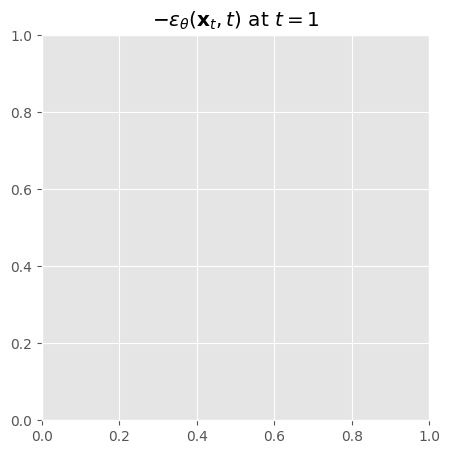

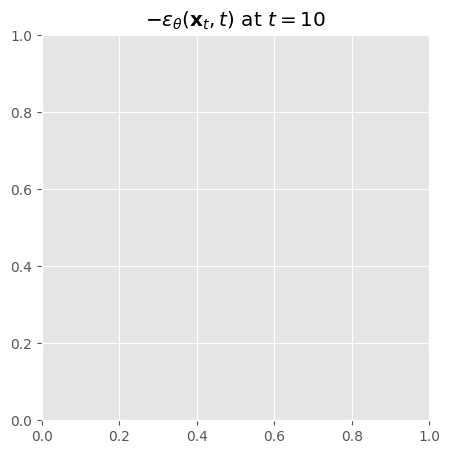

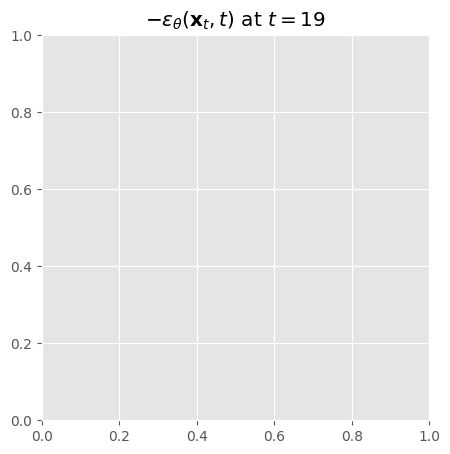

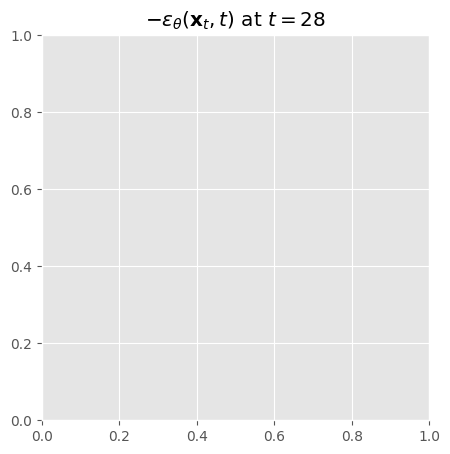

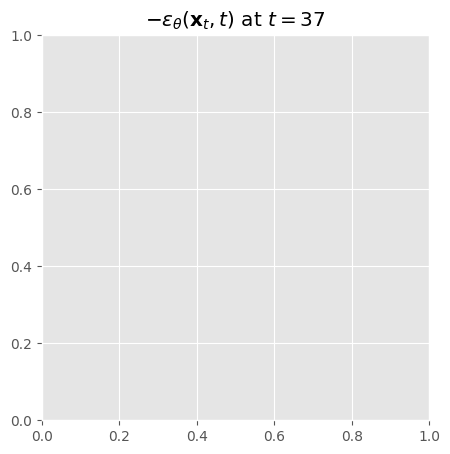

In [18]:
# TODO: show the progression of the estimated scores.
for t in [1, 10, 19, 28, 37]:
    plt.figure(figsize=(5,5))
    ???
    plt.title(r'$-\epsilon_{\theta}(\mathbf{x}_t,t)$' + fr' at $t={t}$')

<img src="assets/code_task_icon.png" style="height:30px;display:inline\"/> **<span style="color:red">Task 10</span>**. Repeat Tasks 6 and 7 using the default settings while reducing the number of diffusion steps to $T=2$, i.e. use `batch_size=1024, nepochs=50, T=2, beta1=2e-4, betaT=2.25e-3`.

<img src="assets/write_task_icon.png" style="height:30px;display:inline\"/> Show the results and discuss any differences (if there's any) compared to $T=40$.

In [19]:
# TODO: repeat tasks 6 and 7 with T=2.
data = sample_2d_datasets('Spiral', num_samples=102400)
diffuser, all_losses = train(data, batch_size=1024, nepochs=50, 
                             T=???
                             , 
                             beta1=2e-4, betaT=2.25e-3, device=device)

eval_data = torch.randn(2048,2).to(device)
diffuser.eps_model.eval()
with torch.no_grad():
    x0, all_epst, all_x0t, all_xt = diffuser.denoise(eval_data, 2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x0[:,0].cpu().numpy(), x0[:,1].cpu().numpy())
plt.title(r'Samples from $p_{\theta}(\mathbf{x}_0)$')
plt.subplot(1,2,2)
plt.scatter(data[:,0], data[:,1])
plt.title(r'Samples from $q(\mathbf{x}_0)$')

SyntaxError: invalid syntax (3028746256.py, line 4)

<img src="assets/code_task_icon.png" style="height:30px;display:inline\"/> **<span style="color:red">Task 11</span>**. Repeat Tasks 6 and 7 for the circles and moons distributions using the default settings `batch_size=1024, nepochs=50, T=40, beta1=2e-4, betaT=2.25e-3`.

<img src="assets/write_task_icon.png" style="height:30px;display:inline\"/> Show the results and discuss any differences (if there's any) compared to the `Spiral` dataset.

In [ ]:
data = sample_2d_datasets(???, num_samples=102400)
diffuser, all_losses = train(data, batch_size=1024, nepochs=50, T=40, beta1=2e-4, betaT=2.25e-3, device=device)

eval_data = torch.randn(2048,2).to(device)
diffuser.eps_model.eval()
with torch.no_grad():
    x0, all_epst, all_x0t, all_xt = diffuser.denoise(eval_data, 40)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x0[:,0].cpu().numpy(), x0[:,1].cpu().numpy())
plt.title(r'Samples from $p_{\theta}(\mathbf{x}_0)$')
plt.subplot(1,2,2)
plt.scatter(data[:,0], data[:,1])
plt.title(r'Samples from $q(\mathbf{x}_0)$')

In [ ]:
data = sample_2d_datasets(???, num_samples=102400)
diffuser, all_losses = train(data, batch_size=1024, nepochs=50, T=40, beta1=2e-4, betaT=2.25e-3, device=device)

eval_data = torch.randn(2048,2).to(device)
diffuser.eps_model.eval()
with torch.no_grad():
    x0, all_epst, all_x0t, all_xt = diffuser.denoise(eval_data, 40)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x0[:,0].cpu().numpy(), x0[:,1].cpu().numpy())
plt.title(r'Samples from $p_{\theta}(\mathbf{x}_0)$')
plt.subplot(1,2,2)
plt.scatter(data[:,0], data[:,1])
plt.title(r'Samples from $q(\mathbf{x}_0)$')

### Conclusion

To conclude, in this part we have seen denoising diffusion models, the current leading generative model in many of the recent technological advancements such as [DALLE](https://openai.com/dall-e-2) and [Imagen](https://imagen.research.google/). As mentioned in the beginning of this part, similar models (much deeper + tricks) are currently leading to state-of-the-art performance in image synthesis, and recently also in solving linear inverse problems. For those of you interested in playing with such models, a lot of great resources are publicly available online, for example [this tutorial](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing) by [Yang Song](https://yang-song.github.io/) who is the author of some key papers in this field. Another great resource is the [Annotated Diffusion Model](https://huggingface.co/blog/annotated-diffusion) provided by Hugging Face.

### What's next?

In Part II of the lab, we explore the application of a *pretrained* diffusion model on the [CelebA-HQ dataset](https://paperswithcode.com/dataset/celeba-hq) which consists of 30,000 face images of celebrities. Beyond exploring the model's sampling capability, we also experiment with the task of image inpainting using a simple modification of Algorithm 2. Finally, we conclude with the fun part of using the recent Text-to-Image model [StableDiffusion](https://stability.ai/news/stable-diffusion-public-release) which can generate images on request using a provided text prompt! 

### References

[1] Sohl-Dickstein, J., et al., "Deep Unsupervised Learning using Nonequilibrium Thermodynamics", ICML (2015) [Link](http://proceedings.mlr.press/v37/sohl-dickstein15.pdf)

[2] Ho, J., et al., "Denoising Diffusion Probabilistic Models", NeuroIPS (2020) [Link](https://proceedings.neurips.cc/paper_files/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf)

[3] Song, Y., et al. "Score-based generative modeling through stochastic differential equations", ICLR (2021). [Link](https://arxiv.org/pdf/2011.13456)

[4] Sinai, L. et al. "Denoising diffusion probabilistic models from first principles", Blog post (2022). [Link](https://liorsinai.github.io/coding/2022/12/03/denoising-diffusion-1-spiral.html#denoising-diffusion-probabilistic-models)